# predict pageviews with earthquakes

## setup

#### imports

In [8]:
import pandas as pd, matplotlib.pyplot as plt, numpy as np
import os
from datetime import datetime, timezone

In [9]:
from holidays_jp import CountryHolidays
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split

from sklearn.svm import SVR

#### get data

In [10]:
def check_coords_in_bbox(latlong:tuple, bounding_boxes:dict=None):    
    if not bounding_boxes:
        bounding_boxes = {
            'Hokkaido': {'minlat':41.241, 'maxlat':45.735, 'minlon':-221.601, 'maxlon':-210.897},
            'Honshu1':  {'minlat':34, 'maxlat':41.241, 'minlon':-222.772, 'maxlon':-217.5},
            'Honshu2':  {'minlat':33,  'maxlat':37, 'minlon':-226.683, 'maxlon':-222.772},
            'Honshu3':  {'minlat':32, 'maxlat':36, 'minlon':-228, 'maxlon':-226.683},
            'Kumamoto': {'minlat':31, 'maxlat':35, 'minlon':-231.466, 'maxlon':-228}
            }
    bbs = bounding_boxes
    
    lat, long_0 = latlong
    long = long_0 if long_0 < 0 else long_0 - 360
    
    for b in bbs:
        if all((bbs[b]['minlat'] < lat,
               bbs[b]['maxlat'] > lat,
               bbs[b]['minlon'] < long,
               bbs[b]['maxlon'] > long)):
            return True
        else:
            continue
    return False

In [11]:
quakes = pd.read_csv('../data/raw/quakes.csv', sep=';', index_col='id')

# fix timezone
quakes['utc_time'] = pd.to_datetime(quakes['datetime'])
quakes['time_jp'] = quakes.utc_time.apply(
    lambda x: x.replace(tzinfo=timezone.utc).astimezone(tz='Japan')  )
quakes['date_jp'] = quakes.time_jp.dt.date
quakes = quakes[['date_jp', 'time_jp', 'lat', 'long', 'mag', 'depth_units?']]

# only keep quakes inside bounding boxes
quakes = quakes[quakes.apply(lambda x: check_coords_in_bbox((x.lat, x.long)), axis=1)]

In [12]:
views = pd.DataFrame()
for y in range(2016,2021):
    df = pd.read_csv(f'../data/processed/jawiki/diz_daily/{y}.csv', 
                     usecols=['Unnamed: 0', '1051_mobile-web', '1051_desktop'])
    df.rename(columns={'Unnamed: 0': 'yyyymmdd_int'}, inplace=True)
    df['date'] = pd.to_datetime(df.yyyymmdd_int.astype(str), format='%Y%m%d')
    df.set_index('date', inplace=True)
    df = df[df.columns.difference(['yyyymmdd_int'])]
    df['1051_x-platform'] = df['1051_desktop'] + df['1051_mobile-web']
    views = pd.concat((views, df), axis=0)
del df

In [13]:
def get_calendar(idx):
    cal = pd.DataFrame(index=idx)
    cal['mtwtf'] = idx.dayofweek.isin([0,1,2,3,4]).astype(int)
    cal['sat'] = idx.dayofweek.isin([5]).astype(int)
    cal['sun'] = idx.dayofweek.isin([6]).astype(int)
    
    years = list(set(idx.year))
    holidays = []
    for y in years:
        holidays.append(CountryHolidays.get('JP', y))
    holidays = pd.DataFrame([i for l in holidays for i in l])
    holidays.set_index(0, inplace=True)
    holidays.rename(columns={1:'holiday_name'}, inplace=True)
    holidays.index = pd.to_datetime(holidays.index)
    
    cal1 = cal.join(holidays, how='left')
    cal1['holiday_name'] = cal1['holiday_name'].fillna(' ')
    cal1['holiday'] = (cal1.holiday_name != ' ').astype(int)
    cal1 = cal1[['mtwtf', 'sat', 'sun', 'holiday']]
    
    # generate dummies for each day of the week (currently unused)
    # cal_7d = pd.DataFrame(index=idx)
    # for i,d in enumerate(['mo','tu','we','th','fr','sa','su']):
    #     cal_7d[d] = idx.dayofweek.isin([i]).astype(int)
    
    return cal1

In [14]:
calendar = get_calendar(views.index)

#### clean magnitudes data

In [15]:
start_date = max(min(views.index.date), min(quakes.date_jp))
end_date = min(max(views.index.date), max(quakes.date_jp))
dates = pd.date_range(start_date, end_date)
mags = pd.DataFrame(None, index=dates, dtype='object')
mags = mags.join(quakes.set_index('date_jp').mag, how='left').squeeze()
mags = mags.groupby(mags.index).max()
mags = mags.fillna(0)
mags6 = (mags > 6).astype(int)

#### explore data

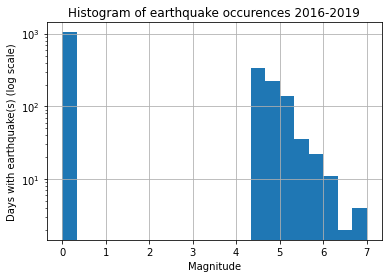

In [16]:
fig = plt.figure()
ax = fig.gca()
mags.hist(bins=21, ax=ax)
ax.set_yscale('log')
ax.set_title('Histogram of earthquake occurences 2016-2019')
ax.set_xlabel('Magnitude')
ax.set_ylabel('Days with earthquake(s) (log scale)')
plt.show()

<AxesSubplot:xlabel='date'>

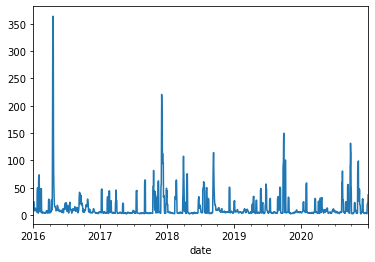

In [17]:
views['1051_x-platform'].rolling(5).mean().plot()

<AxesSubplot:xlabel='date'>

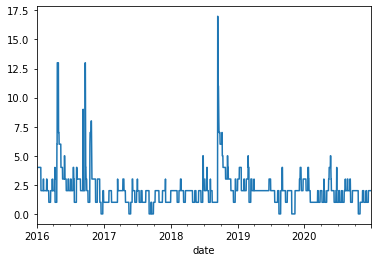

In [18]:
views['1051_x-platform'].rolling(10).min().plot()

## modeling

#### naive regression on quakes only

In [19]:
lr1 = LinearRegression()

In [20]:
x1_4 = mags.shift(1).dropna() > 4
x1_5 = mags.shift(1).dropna() > 5
x1_6 = mags.shift(1).dropna() > 6
x1_7 = mags.shift(1).dropna() > 7
X1 = pd.concat((x1_4,x1_5,x1_6,x1_7), axis=1).astype(int)

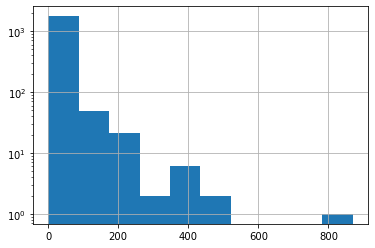

In [21]:
views.iloc[:, 2].hist()
plt.yscale('log')

In [22]:
y1 = views.loc[X1.index, '1051_x-platform'].to_frame().applymap(lambda x: np.log(x)).fillna(0).replace(-np.inf, 0)

/tmp/ipykernel_7374/4126711420.py:1: RuntimeWarning: divide by zero encountered in log
  y1 = views.loc[X1.index, '1051_x-platform'].to_frame().applymap(lambda x: np.log(x)).fillna(0).replace(-np.inf, 0)


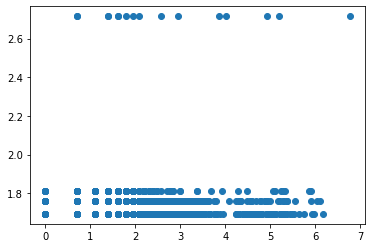

In [23]:
lr1.fit(X1, y1)
preds1 = pd.Series(lr1.predict(X1).flatten())
plt.scatter(y1, preds1)

In [24]:
lr1.coef_

array([[0.06543067, 0.05508073, 0.90153019, 0.        ]])

It seems that looking at earthquakes with magnitude > 6 gives the best result.

#### not-quite-ARIMA without quakes

In [25]:
ts = views['1051_x-platform']
ts[ts < 4] = 1
ts = views['1051_x-platform'].apply(lambda x: np.log(x))
ar1 = ts.shift(1).rename('ar1')
ma7 = ts.rolling(6, closed='left').mean().rename('ma7')

X2 = pd.concat((ar1, ma7, calendar), axis=1).dropna()
y2 = ts[X2.index]

In [26]:
X2tr, X2te, y2tr, y2te = train_test_split(X2, y2, shuffle=True, test_size=.3)

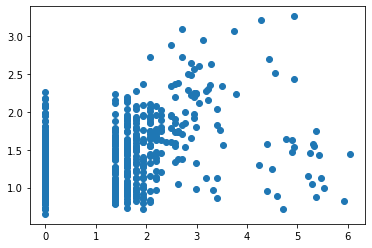

In [27]:
lr2 = LinearRegression()
lr2.fit(X2tr, y2tr)
preds2 = lr2.predict(X2te)
plt.scatter(y2te.to_numpy(), preds2, cmap='winter')

In [28]:
print(X2.columns.to_list())
print(lr2.coef_.round(3))
print(np.round(lr2.score(X2te, y2te), 3))

['ar1', 'ma7', 'mtwtf', 'sat', 'sun', 'holiday']
[ 0.25   0.283 -0.051  0.029  0.021  0.044]
0.091


#### not-quite-ARIMA with quakes

In [29]:
ts = views['1051_x-platform']
ts[ts < 4] = 1
ts = views['1051_x-platform'].apply(lambda x: np.log(x))

In [30]:
ar1 = ts.shift(1).rename('ar1')
ma7 = ts.rolling(6, closed='left').mean().rename('ma7')
mags_l1_over_58 = (mags.shift(1).dropna() >= 5.8).astype(int).rename('mag_over_58')

X3 = pd.concat((ar1, ma7, calendar, mags_l1_over_58), axis=1).dropna()
y3 = ts[X3.index]

In [31]:
X3tr, X3te, y3tr, y3te = train_test_split(X3, y3, shuffle=True, test_size=.3, stratify=X3.mag_over_58)

In [32]:
lr3 = LinearRegression()
lr3.fit(X3tr, y3tr)
preds3 = lr3.predict(X3te)

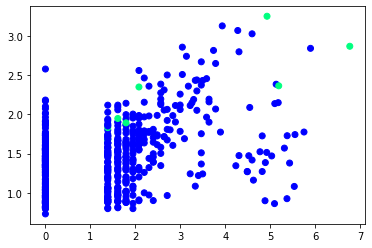

In [33]:
plt.scatter(y3te.to_numpy(), preds3, c=X3te.mag_over_58, cmap='winter')

In [34]:
print(X3.columns.to_list())
print(lr3.coef_.round(3))
print(np.round(lr3.score(X3te, y3te), 3))

['ar1', 'ma7', 'mtwtf', 'sat', 'sun', 'holiday', 'mag_over_58']
[ 0.194  0.291 -0.022  0.027 -0.006  0.08   0.267]
0.167


#### real ARIMA (without calendar)

In [35]:
from statsmodels.tsa.arima.model import ARIMA

In [36]:
ts = views['1051_x-platform']

In [37]:
x4_mags = mags6.shift(1).dropna() # manually lag the earthquake magnitudes
x4_cal = calendar.loc[x4_mags.index] # no lag on the calendar inputs
X4 = pd.concat((x4_cal, x4_mags), axis=1)
y4 = ts[X4.index]
nobs = y4.shape[0]

In [ ]:
forecasts = {}
for i in range(732, nobs):
    Xtr = X4[:i]
    ytr = y4[:i]
    arima4 = ARIMA(endog=ytr, exog=Xtr, order=(1,0,3), freq='D')
    arima4_fit = arima4.fit()
    forecasts[y4.index[i]] = arima4_fit.forecast(steps=1, exog=X4.iloc[i]).values[0]

pd.Series(forecasts, name='forecast_views4').to_csv('../data/processed/forecast_views4.csv', sep=';')

/home/ubuntu/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/ubuntu/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/ubuntu/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/ubuntu/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/ubuntu/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_mo

/home/ubuntu/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/ubuntu/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/ubuntu/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/ubuntu/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/ubuntu/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:5

/home/ubuntu/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/ubuntu/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/ubuntu/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/ubuntu/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/ubuntu/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:5

/home/ubuntu/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/ubuntu/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/ubuntu/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/ubuntu/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/ubuntu/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:5

In [ ]:
pd.read_csv('../data/processed/forecast4.csv', sep=';')